<a href="https://colab.research.google.com/github/TonkomoLLC/LBMStuff/blob/main/Copy_of_notebookLBM_version0_1_public.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title
%%html
<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" href="http://purl.org/dc/dcmitype/InteractiveResource" property="dct:title" rel="dct:type">notebookLBM</span> by <a xmlns:cc="http://creativecommons.org/ns#" href="https://orcid.org/0000-0001-8403-8943" property="cc:attributionName" rel="cc:attributionURL">Nilesh Sawant</a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.<br />Based on a work at <a xmlns:dct="http://purl.org/dc/terms/" href="https://jupyter.org/about" rel="dct:source">https://jupyter.org/about</a>.<br />Permissions beyond the scope of this license may be available at <a xmlns:cc="http://creativecommons.org/ns#" href="https://www.researchgate.net/profile/Nilesh-Sawant-2" rel="cc:morePermissions">https://www.researchgate.net/profile/Nilesh-Sawant-2</a>.

1. To run this notebook: Runtime > Run all
2. To try changes without changing this file: File > Open in playground mode
3. To execute one cell: Place cursor in the cell > Click play button (or) Ctrl + enter (or) Shift + enter
4. Your copy with changes can be saved by: File > Save a copy in Drive
5. Module missing? Execute "!pip install nameOfmodule" in a cell

In [ ]:
#!pip install cupy #Example cell to demonstrate missing module installation
#!nvcc --version
#!pip install cupy-cuda111 -U

In [ ]:
#@title Load modules
import os
from IPython import display
import matplotlib.pyplot as plt
import copy
import time
#import sodshock
from pathlib import Path
Path("results").mkdir(parents=True, exist_ok=True)
from numba import jit, njit, prange
from numba import vectorize, float64
from numba import stencil
!pip install sodshock

In [ ]:
#@title Select GPU/CPU
GPU=True

if GPU:
    import cupy as np,cupyx.scipy as sp, numpy as npcpu #gpu
    from cupy import asnumpy
else:
    #os.environ["MKL_NUM_THREADS"] = '2'
    #os.environ["OMP_NUM_THREADS"] = '2'
    import numpy as np,scipy as sp, numpy as npcpu #cpu
    def asnumpy(x_):
        return x_

In [ ]:
#@title Lattice definition
#D3Q27

cSC1 = 1;
cFCC1= 1;
cBCC1= 1;

vX=np.array([0  , cSC1, -cSC1, 0  ,  0  ,  0  ,  0  ,  cFCC1, -cFCC1,  cFCC1, -cFCC1, cFCC1, -cFCC1,  cFCC1, -cFCC1, 0  ,  0  ,  0  ,  0  ,  cBCC1, -cBCC1,  cBCC1, -cBCC1,  cBCC1, -cBCC1,  cBCC1, -cBCC1]);
vY=np.array([0  , 0  ,  0  , cSC1, -cSC1,  0  ,  0  ,  cFCC1, -cFCC1, -cFCC1,  cFCC1, 0  ,  0  ,  0  ,  0  , cFCC1, -cFCC1,  cFCC1, -cFCC1,  cBCC1, -cBCC1, -cBCC1,  cBCC1, -cBCC1,  cBCC1,  cBCC1, -cBCC1]);
vZ=np.array([0  , 0  ,  0  , 0  ,  0  ,  cSC1, -cSC1,  0  ,  0  ,  0  ,  0  , cFCC1, -cFCC1, -cFCC1,  cFCC1, cFCC1, -cFCC1, -cFCC1,  cFCC1,  cBCC1, -cBCC1,  cBCC1, -cBCC1, -cBCC1,  cBCC1, -cBCC1,  cBCC1]);

ndV=vX.size
vMax=int(np.ceil(np.max(vX)))

wSC1   = 2.0/27.0;
wFCC1  = 1.0/54.0;
wBCC1  = 1.0/216.0;
w0 = 1.0 - (6.0*(wSC1) + 12.0*(wFCC1) + 8.0*(wBCC1));
theta0 = 1.0/3.0;
oneByTheta0=1.0/theta0

wt = np.array([w0,wSC1,wSC1,wSC1,wSC1,wSC1,wSC1,wFCC1,wFCC1,wFCC1,wFCC1,wFCC1,wFCC1,wFCC1,wFCC1,wFCC1,wFCC1,wFCC1,wFCC1,wBCC1,wBCC1,wBCC1,wBCC1,wBCC1,wBCC1,wBCC1,wBCC1]);

assert vX.size==vY.size==vZ.size==wt.size

nM=17
g_nM=10

class mNames:
    def __init__(self,nM_):
        self.rho,self.jx,self.jy,self.jz,self.Pxx,self.Pyy,self.Pzz,self.Pxy,self.Pxz,self.Pyz,self.Qxxy,self.Qxxz,self.Qyyx,self.Qyyz,self.Qzzx,self.Qzzy,self.Qxyz=range(nM_)

class g_mNames:
    def __init__(self,g_nM_):
        self.twoRhoE,self.qx,self.qy,self.qz,self.Rxx,self.Ryy,self.Rzz,self.Rxy,self.Rxz,self.Ryz=range(g_nM_)


m=mNames(nM)
g_m=g_mNames(g_nM)

matrixV=np.zeros((ndV,nM))

matrixV[:,m.rho]=np.ones(ndV)
matrixV[:,m.jx]=vX;
matrixV[:,m.jy]=vY;
matrixV[:,m.jz]=vZ;
matrixV[:,m.Pxx]=vX*vX;
matrixV[:,m.Pyy]=vY*vY;
matrixV[:,m.Pzz]=vZ*vZ;
matrixV[:,m.Pxy]=vX*vY;
matrixV[:,m.Pxz]=vX*vZ;
matrixV[:,m.Pyz]=vY*vZ;
matrixV[:,m.Qxxy]=vX*vX*vY;
matrixV[:,m.Qxxz]=vX*vX*vZ;
matrixV[:,m.Qyyx]=vY*vY*vX;
matrixV[:,m.Qyyz]=vY*vY*vZ;
matrixV[:,m.Qzzx]=vZ*vZ*vX;
matrixV[:,m.Qzzy]=vZ*vZ*vY;
matrixV[:,m.Qxyz]=vX*vY*vZ

matrixVinv=np.linalg.pinv(matrixV)

g_matrixV=matrixV[:,:g_nM].copy()

g_matrixVinv=np.linalg.pinv(g_matrixV)
print((matrixVinv@matrixV).min(),(g_matrixVinv@g_matrixV).min())

-1.304512053934559e-15 -1.9130108485730683e-15


In [ ]:
#@title Moment definitions
def getTemperature(twoRhoE_,rho_,ux_,uy_,uz_,Cv_):
    return (0.50/Cv_)*((twoRhoE_/rho_) - (ux_*ux_ + uy_*uy_ + uz_*uz_))

def getEnergy(T_,rho_,ux_,uy_,uz_,Cv_):
    return rho_*(2.0*Cv_*T_ + (ux_*ux_ + uy_*uy_ + uz_*uz_) )

def getEquilibriumMomentsTwoPopStandardLatticeReturn(moments_,g_moments_):
    momentsEq_=np.empty_like(moments_)
    g_momentsEq_=np.empty_like(g_moments_)

    momentsEq_[:,:,:,m.rho:m.jz+1]=moments_[:,:,:,m.rho:m.jz+1]*1.0

    #moments_[:,:,:,m.jx:m.jz+1] /= moments_[:,:,:,m.rho:m.rho+1]
    moments_[:,:,:,m.jx] /= moments_[:,:,:,m.rho]
    moments_[:,:,:,m.jy] /= moments_[:,:,:,m.rho]
    moments_[:,:,:,m.jz] /= moments_[:,:,:,m.rho]

    T_=getTemperature(g_moments_[:,:,:,g_m.twoRhoE],moments_[:,:,:,m.rho],moments_[:,:,:,m.jx],moments_[:,:,:,m.jy],moments_[:,:,:,m.jz],Cv)[:,:,:,np.newaxis]

    momentsEq_[:,:,:,m.Pxx]=moments_[:,:,:,m.rho]*(moments_[:,:,:,m.jx]*moments_[:,:,:,m.jx] + T_[:,:,:,0])
    momentsEq_[:,:,:,m.Pyy]=moments_[:,:,:,m.rho]*(moments_[:,:,:,m.jy]*moments_[:,:,:,m.jy] + T_[:,:,:,0])
    momentsEq_[:,:,:,m.Pzz]=moments_[:,:,:,m.rho]*(moments_[:,:,:,m.jz]*moments_[:,:,:,m.jz] + T_[:,:,:,0])
    momentsEq_[:,:,:,m.Pxy]=moments_[:,:,:,m.rho]*moments_[:,:,:,m.jx]*moments_[:,:,:,m.jy]
    momentsEq_[:,:,:,m.Pxz]=moments_[:,:,:,m.rho]*moments_[:,:,:,m.jx]*moments_[:,:,:,m.jz]
    momentsEq_[:,:,:,m.Pyz]=moments_[:,:,:,m.rho]*moments_[:,:,:,m.jy]*moments_[:,:,:,m.jz]

    momentsEq_[:,:,:,m.Qxxy]=moments_[:,:,:,m.rho]*(moments_[:,:,:,m.jx]*moments_[:,:,:,m.jx]*moments_[:,:,:,m.jy]+T_[:,:,:,0]*moments_[:,:,:,m.jy])
    momentsEq_[:,:,:,m.Qxxz]=moments_[:,:,:,m.rho]*(moments_[:,:,:,m.jx]*moments_[:,:,:,m.jx]*moments_[:,:,:,m.jz]+T_[:,:,:,0]*moments_[:,:,:,m.jz])
    momentsEq_[:,:,:,m.Qyyx]=moments_[:,:,:,m.rho]*(moments_[:,:,:,m.jy]*moments_[:,:,:,m.jy]*moments_[:,:,:,m.jx]+T_[:,:,:,0]*moments_[:,:,:,m.jx])
    momentsEq_[:,:,:,m.Qyyz]=moments_[:,:,:,m.rho]*(moments_[:,:,:,m.jy]*moments_[:,:,:,m.jy]*moments_[:,:,:,m.jz]+T_[:,:,:,0]*moments_[:,:,:,m.jz])
    momentsEq_[:,:,:,m.Qzzx]=moments_[:,:,:,m.rho]*(moments_[:,:,:,m.jz]*moments_[:,:,:,m.jz]*moments_[:,:,:,m.jx]+T_[:,:,:,0]*moments_[:,:,:,m.jx])
    momentsEq_[:,:,:,m.Qzzy]=moments_[:,:,:,m.rho]*(moments_[:,:,:,m.jz]*moments_[:,:,:,m.jz]*moments_[:,:,:,m.jy]+T_[:,:,:,0]*moments_[:,:,:,m.jy])
    momentsEq_[:,:,:,m.Qxyz]=moments_[:,:,:,m.rho]*moments_[:,:,:,m.jx]*moments_[:,:,:,m.jy]*moments_[:,:,:,m.jz]

    g_momentsEq_[:,:,:,g_m.twoRhoE]=g_moments_[:,:,:,g_m.twoRhoE]*1.0
    g_momentsEq_[:,:,:,g_m.qx]=moments_[:,:,:,m.jx]*(g_moments_[:,:,:,g_m.twoRhoE]+2.0*moments_[:,:,:,m.rho]*T_[:,:,:,0])
    g_momentsEq_[:,:,:,g_m.qy]=moments_[:,:,:,m.jy]*(g_moments_[:,:,:,g_m.twoRhoE]+2.0*moments_[:,:,:,m.rho]*T_[:,:,:,0])
    g_momentsEq_[:,:,:,g_m.qz]=moments_[:,:,:,m.jz]*(g_moments_[:,:,:,g_m.twoRhoE]+2.0*moments_[:,:,:,m.rho]*T_[:,:,:,0])

    g_momentsEq_[:,:,:,g_m.Rxx]=g_moments_[:,:,:,g_m.twoRhoE]*(moments_[:,:,:,m.jx]*moments_[:,:,:,m.jx]+T_[:,:,:,0]) + 2.0*moments_[:,:,:,m.rho]*T_[:,:,:,0]*(2.0*moments_[:,:,:,m.jx]*moments_[:,:,:,m.jx]+T_[:,:,:,0])
    g_momentsEq_[:,:,:,g_m.Ryy]=g_moments_[:,:,:,g_m.twoRhoE]*(moments_[:,:,:,m.jy]*moments_[:,:,:,m.jy]+T_[:,:,:,0]) + 2.0*moments_[:,:,:,m.rho]*T_[:,:,:,0]*(2.0*moments_[:,:,:,m.jy]*moments_[:,:,:,m.jy]+T_[:,:,:,0])
    g_momentsEq_[:,:,:,g_m.Rzz]=g_moments_[:,:,:,g_m.twoRhoE]*(moments_[:,:,:,m.jz]*moments_[:,:,:,m.jz]+T_[:,:,:,0]) + 2.0*moments_[:,:,:,m.rho]*T_[:,:,:,0]*(2.0*moments_[:,:,:,m.jz]*moments_[:,:,:,m.jz]+T_[:,:,:,0])

    g_momentsEq_[:,:,:,g_m.Rxy]=g_moments_[:,:,:,g_m.twoRhoE]*(moments_[:,:,:,m.jx]*moments_[:,:,:,m.jy]) + 2.0*moments_[:,:,:,m.rho]*T_[:,:,:,0]*(2.0*moments_[:,:,:,m.jx]*moments_[:,:,:,m.jy])
    g_momentsEq_[:,:,:,g_m.Rxz]=g_moments_[:,:,:,g_m.twoRhoE]*(moments_[:,:,:,m.jx]*moments_[:,:,:,m.jz]) + 2.0*moments_[:,:,:,m.rho]*T_[:,:,:,0]*(2.0*moments_[:,:,:,m.jx]*moments_[:,:,:,m.jz])
    g_momentsEq_[:,:,:,g_m.Ryz]=g_moments_[:,:,:,g_m.twoRhoE]*(moments_[:,:,:,m.jy]*moments_[:,:,:,m.jz]) + 2.0*moments_[:,:,:,m.rho]*T_[:,:,:,0]*(2.0*moments_[:,:,:,m.jy]*moments_[:,:,:,m.jz])

    moments_[:,:,:,m.jx] *= moments_[:,:,:,m.rho]
    moments_[:,:,:,m.jy] *= moments_[:,:,:,m.rho]
    moments_[:,:,:,m.jz] *= moments_[:,:,:,m.rho]

    return momentsEq_,g_momentsEq_,T_

In [ ]:
#@title Sod test case
#sod test tube

nX=3000;nY=1;nZ=1;
dx=dy=dz=1.0

gamma=2.0
cs=np.sqrt(gamma*theta0)

rho0=0.50
ux0=0.00
uy0=0.00
uz0=0.00
T0=0.20 #theta0

nu=0.004
Prandtl=1.0
alpha=nu/Prandtl

dt=1.0

tau=nu/T0
oneByTau=1.0/tau
beta=1.0/(2.0*(tau/dt)+1.0)
Cv=1.0/(gamma-1.0)

pX=pY=pZ=vMax

grid_f=np.zeros((nZ+2*pZ,nY+2*pY,nX+2*pX,ndV))
grid_g=np.zeros((nZ+2*pZ,nY+2*pY,nX+2*pX,ndV))
print('dt=',dt,',nu=',nu,',Pr=',Prandtl,',alpha=',alpha,',gamma=',gamma,',Cv=',Cv,sep='')

def smooth(left,right,pos,scale):
    return left + 0.5*(1.0+np.tanh(pos*scale))*(right-left)

def ic_sod(moments_,g_moments_):
    smoothening=3.0
    rho_L=rho0
    rho_R=4.0*rho_L
    T_L=T0
    T_R=0.125*T_L

    for i in range(0,nX+2*pX):
        #print(rho0)
        moments_[:,:,i,m.rho]=smooth(rho_L,rho_R,(i-pX)*1.0-0.5*(nX-1.0),smoothening)

    for i in range(0,nX+2*pX):
        moments_[:,:,i,m.jx]=moments_[:,:,i,m.rho]*ux0
        moments_[:,:,i,m.jy]=moments_[:,:,i,m.rho]*uy0
        moments_[:,:,i,m.jz]=moments_[:,:,i,m.rho]*uz0
        g_moments_[:,:,i,g_m.twoRhoE]=getEnergy(smooth(T_L,T_R,(i-pX)*1.0-0.5*(nX-1.0),smoothening),
                                                moments_[:,:,i,m.rho],
                                                moments_[:,:,i,m.jx]/moments_[:,:,i,m.rho],moments_[:,:,i,m.jy]/moments_[:,:,i,m.rho],moments_[:,:,i,m.jz]/moments_[:,:,i,m.rho]
                                                ,Cv)

    return moments_,g_moments_

dt=1.0,nu=0.004,Pr=1.0,alpha=0.004,gamma=2.0,Cv=1.0


In [ ]:
#@title Viscosity test case
# #viscosity test
# nX=10;nY=200;nZ=2;
# dx=dy=dz=1.0

# gamma=1.40
# cs=np.sqrt(gamma*theta0)

# rho0=1.0
# T0=0.10 #theta0
# u0=0.4*np.sqrt(gamma*T0)
# ux0=0.00
# uy0=u0
# uz0=0.00

# nu=0.05
# Prandtl=1.0
# alpha=nu/Prandtl

# dt=1.0

# tau=nu/T0
# oneByTau=1.0/tau
# beta=1.0/(2.0*(tau/dt)+1.0)
# Cv=1.0/(gamma-1.0)

# pX=pY=pZ=int(np.ceil(np.max(vX)))

# grid_f=np.zeros((nZ+2*pZ,nY+2*pY,nX+2*pX,ndV))
# grid_g=np.zeros((nZ+2*pZ,nY+2*pY,nX+2*pX,ndV))
# print('dt=',dt,',nu=',nu,',Pr=',Prandtl,',alpha=',alpha,',gamma=',gamma,',Cv=',Cv,sep='')

# def ic_viscosity(moments_,g_moments_):
#     a0=0.001
#     moments_[:,:,:,m.rho]=rho0
#     moments_[:,:,:,m.jy]=rho0*uy0
#     moments_[:,:,:,m.jz]=rho0*uz0

#     for j in range(0,nY+2*pY):
#         moments_[:,j,:,m.jx]=a0*np.sin(2.0*np.pi*j/nY)
#         g_moments_[:,j,:,g_m.twoRhoE]=getEnergy(T0,
#                                                 moments_[:,j,:,m.rho],
#                                                 moments_[:,j,:,m.jx]/moments_[:,j,:,m.rho],moments_[:,j,:,m.jy]/moments_[:,j,:,m.rho],moments_[:,j,:,m.jz]/moments_[:,j,:,m.rho]
#                                                 ,Cv)

#     return moments_,g_moments_

In [ ]:
#@title Thermal diffusivity test case
# #thermal diffusivity test

# nX=10;nY=200;nZ=2;
# dx=dy=dz=1.0

# gamma=1.40
# cs=np.sqrt(gamma*theta0)

# rho0=1.0
# T0=0.10 #theta0
# u0=0.4*np.sqrt(gamma*T0)
# ux0=u0
# uy0=0.0
# uz0=0.00

# nu=0.05
# Prandtl=2.0
# alpha=nu/Prandtl

# dt=1.0

# tau=nu/T0
# oneByTau=1.0/tau
# beta=1.0/(2.0*(tau/dt)+1.0)
# Cv=1.0/(gamma-1.0)

# pX=pY=pZ=int(np.ceil(np.max(vX)))

# grid_f=np.zeros((nZ+2*pZ,nY+2*pY,nX+2*pX,ndV))
# grid_g=np.zeros((nZ+2*pZ,nY+2*pY,nX+2*pX,ndV))
# print('dt=',dt,',nu=',nu,',Pr=',Prandtl,',alpha=',alpha,',gamma=',gamma,',Cv=',Cv,sep='')

# def ic_thermalDiffusivity(moments_,g_moments_):
#     a0=0.001
#     moments_[:,:,:,m.jy]=rho0*ux0
#     moments_[:,:,:,m.jy]=rho0*uy0
#     moments_[:,:,:,m.jz]=rho0*uz0

#     for j in range(0,nY+2*pY):
#         moments_[:,j,:,m.rho]=rho0+a0*np.sin(2.0*np.pi*j/nY)

#     for j in range(0,nY+2*pY):
#         g_moments_[:,j,:,g_m.twoRhoE]=getEnergy(rho0*T0/moments_[:,j,:,m.rho],
#                                                 moments_[:,j,:,m.rho],
#                                                 moments_[:,j,:,m.jx]/moments_[:,j,:,m.rho],moments_[:,j,:,m.jy]/moments_[:,j,:,m.rho],moments_[:,j,:,m.jz]/moments_[:,j,:,m.rho]
#                                                 ,Cv)

#     return moments_,g_moments_

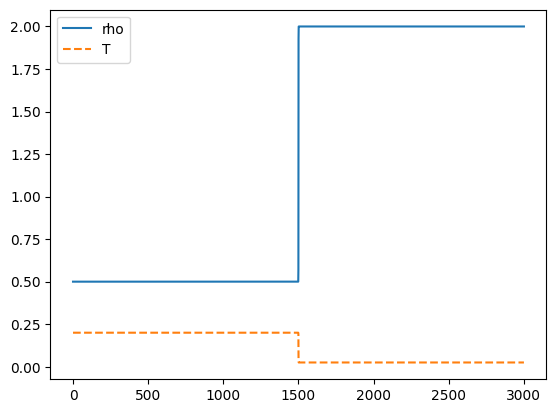

In [ ]:
#@title Initialize (sod)
# inititalization

moments=np.zeros(grid_f.shape[:-1]+(nM,))
g_moments=np.zeros(grid_g.shape[:-1]+(g_nM,))

moments,g_moments=ic_sod(moments,g_moments)
#moments,g_moments=ic_viscosity(moments,g_moments)
#moments,g_moments=ic_thermalDiffusivity(moments,g_moments)

momentsEq,g_momentsEq,T_ic=getEquilibriumMomentsTwoPopStandardLatticeReturn(moments,g_moments)
grid_f=momentsEq@matrixVinv
grid_g=g_momentsEq@g_matrixVinv

moments=grid_f@matrixV
g_moments=grid_g@g_matrixV

#verify ic_sod
plt.plot(npcpu.arange(0,nX+2*pX)*dx,asnumpy(moments[pZ,pY,:,m.rho]),'-',label='rho')
plt.plot(npcpu.arange(0,nX+2*pX)*dx,asnumpy(T_ic[pZ,pY,:,0]),'--',label='T')

#verify ic_viscosity
#plt.plot(asnumpy(np.arange(0,nY+2*pY)*dx),asnumpy(moments[pZ,:,pX,m.jx]/moments[pZ,:,pX,m.rho]),'-',label='ux')

#verify ic_thermalDiffusivity
#plt.plot(asnumpy(np.arange(0,nY+2*pY)*dx),asnumpy(T_ic[pZ,:,pX,0]),'-',label='T')

plt.legend(loc='best')
del moments
del momentsEq
del g_moments
del g_momentsEq
del T_ic

In [ ]:
#@title

def minmod(sL_,sR_):
    slope_=0.0*sL_;
    slope_=(np.sign(sL_)==np.sign(sR_))*np.sign(sL_)*np.minimum(np.abs(sL_),np.abs(sR_))
    return slope_

def maxmod(sL_,sR_):
    slope_=0.0*sL_;
    slope_=(np.sign(sL_)==np.sign(sR_))*np.sign(sL_)*np.maximum(np.abs(sL_),np.abs(sR_))
    return slope_

def minmodM(sL_,sM_,sR_):
    slope_=0.0*sL_;
    slope_=( np.logical_and((np.sign(sL_)==np.sign(sM_)),(np.sign(sM_)==np.sign(sR_))) )*np.sign(sL_)*np.minimum(np.abs(sL_),np.abs(sM_),np.abs(sR_))
    return slope_

def vanLeer(sL,sR):
    slope=(np.abs(sR)*sL+sR*np.abs(sL))/(np.abs(sL)+np.abs(sR))
    slope[~np.isfinite(slope)] = 0.0
    return slope

def monotonizedCentral(sL,sR):
    return minmodM(2.0*sL,0.5*(sL+sR),2.0*sR)

def superbee(sL,sR):
    return maxmod(minmod(2.0*sL,sR),minmod(sL,2.0*sR))


In [ ]:
#@title Boundary conditions
def allPeriodic(f):
    f[:,:,:pX,:] = f[:,:,nX:nX+pX,:]
    f[:,:,nX+pX:,:] = f[:,:,pX:pX+pX,:]

    f[:,:pY,:,:] = f[:,nY:nY+pY,:,:]
    f[:,nY+pY:,:,:] = f[:,pY:pY+pY,:,:]

    f[:pZ,:,:,:] = f[nZ:nZ+pZ,:,:,:]
    f[nZ+pZ:,:,:,:] = f[pZ:pZ+pZ,:,:,:]

def allPeriodicWithReturn(f_in):
    #f=f_in.copy()
    f_in[:,:,:pX,:] = f_in[:,:,nX:nX+pX,:]
    f_in[:,:,nX+pX:,:] = f_in[:,:,pX:pX+pX,:]

    f_in[:,:pY,:,:] = f_in[:,nY:nY+pY,:,:]
    f_in[:,nY+pY:,:,:] = f_in[:,pY:pY+pY,:,:]

    f_in[:pZ,:,:,:] = f_in[nZ:nZ+pZ,:,:,:]
    f_in[nZ+pZ:,:,:,:] = f_in[pZ:pZ+pZ,:,:,:]
    return f_in

def xGradWithReturn(f_in):
    #f=f_in.copy()
    f_in[:,:,:pX,:] = f_in[:,:,pX:pX+1,:]
    f_in[:,:,nX+pX:,:] = f_in[:,:,nX+pX-1:nX+pX-1+1,:]
    return f_in


In [ ]:
#@title Advection
# Collision Pr>1: https://doi.org/10.1063/5.0048029
# Collision Pr<1: https://doi.org/10.1017/jfm.2022.345
# Off-Lattice Advection: https://doi.org/10.3929/ethz-b-000607045

#Do not change the weights
phi=1.0
dtP1=1.0+dt
w0o2=0.5*dtP1*dtP1-1.5*dtP1+1.0;
w1o2=-dtP1*dtP1+2.0*dtP1;
w2o2=0.5*dtP1*dtP1-0.5*dtP1;
wMinusOneAdv=w2o2*phi+dt*(1.0-phi)
wPlusOneAdv=w0o2*phi+0.0*(1.0-phi)
wSelfAdv=w1o2*phi+(1.0-dt)*(1.0-phi)


def advectWithReturn_GPU(f_in):
    f=f_in #.copy() #Enable copy if advection is unpredictable. Safety off for memory optimization. Race possible

    # for dv in range(1,ndV):
    #     f[pZ:f.shape[0]-pZ,pY:f.shape[1]-pY,pX:f.shape[2]-pX,dv]=f_in[pZ-int(vZ[dv]):f.shape[0]-pZ-int(vZ[dv]),pY-int(vY[dv]):f.shape[1]-pY-int(vY[dv]),pX-int(vX[dv]):f.shape[2]-pX-int(vX[dv]),dv]

    #enable for off-lattice
    for dv in prange(1,ndV):
        f[pZ:f.shape[0]-pZ,pY:f.shape[1]-pY,pX:f.shape[2]-pX,dv] = (wMinusOneAdv*f_in[pZ-int(vZ[dv]):f.shape[0]-pZ-int(vZ[dv]),pY-int(vY[dv]):f.shape[1]-pY-int(vY[dv]),pX-int(vX[dv]):f.shape[2]-pX-int(vX[dv]),dv]
                                                                   +wPlusOneAdv*f_in[pZ+int(vZ[dv]):f.shape[0]-pZ+int(vZ[dv]),pY+int(vY[dv]):f.shape[1]-pY+int(vY[dv]),pX+int(vX[dv]):f.shape[2]-pX+int(vX[dv]),dv]
                                                                   +wSelfAdv*f_in[pZ:f.shape[0]-pZ,pY:f.shape[1]-pY,pX:f.shape[2]-pX,dv])

    return f

@stencil(neighborhood = ((-vMax,vMax),(-vMax,vMax),(-vMax,vMax),))
def advectionKernel(f,cz,cy,cx):
    return wMinusOneAdv*f[-cz,-cy,-cx]+wSelfAdv*f[0,0,0]+wPlusOneAdv*f[cz,cy,cx]

@jit(nopython=True,parallel=True)
def advectWithReturn_numba(f_in):
    f=f_in.copy()

    #enable for off-lattice
    for dv in prange(1,ndV):
        f[:,:,:,dv] = advectionKernel(f_in[:,:,:,dv],vZ[dv],vY[dv],vX[dv])

    return f

if GPU:
    advectWithReturn=advectWithReturn_GPU
else:
    advectWithReturn=advectWithReturn_numba



In [ ]:
#@title Collision
def collideTwoPopStandardLatticeWithReturn(grid_f_,grid_g_):
    #f_out=np.empty_like(grid_f_)
    moments=grid_f_@matrixV
    g_moments=grid_g_@g_matrixV

    momentsEq,g_momentsEq,T=getEquilibriumMomentsTwoPopStandardLatticeReturn(moments,g_moments)

    ux=moments[:,:,:,m.jx]/moments[:,:,:,m.rho]
    uy=moments[:,:,:,m.jy]/moments[:,:,:,m.rho]
    uz=moments[:,:,:,m.jz]/moments[:,:,:,m.rho]

    corrX=moments[:,:,:,m.jx]*((1.0-3.0*T[:,:,:,0])-ux*ux)
    corrY=moments[:,:,:,m.jy]*((1.0-3.0*T[:,:,:,0])-uy*uy)
    corrZ=moments[:,:,:,m.jz]*((1.0-3.0*T[:,:,:,0])-uz*uz)

    omega=2.0/((2.0*(nu/dt)/T)+1.0)
    omega1=2.0/((2.0*(alpha/dt)/T)+1.0)
    omega1Byomega=omega1/omega
    omegaCorr=((2.0-omega)/(2.0*omega))

    d_corrX=np.empty_like(corrX)
    d_corrY=np.empty_like(corrY)
    d_corrZ=np.empty_like(corrZ)

    #backward difference
    d_corrX[1:,:,:] = corrX[1:,:,:] - corrX[:-1,:,:]
    d_corrY[:,1:,:] = corrY[:,1:,:] - corrY[:,:-1,:]
    d_corrZ[:,:,1:] = corrZ[:,:,1:] - corrZ[:,:,:-1]

    corrX[1:-1,:,:]=limiter(d_corrX[1:-1,:,:],d_corrX[2:,:,:])
    corrY[:,1:-1,:]=limiter(d_corrY[:,1:-1,:],d_corrY[:,2:,:])
    corrZ[:,:,1:-1]=limiter(d_corrZ[:,:,1:-1],d_corrZ[:,:,2:])

    corrX *= dt #compute optimization
    corrY *= dt #compute optimization
    corrZ *= dt #compute optimization

    moments[:,:,:,m.Pxx:m.Pyz+1] -= momentsEq[:,:,:,m.Pxx:m.Pyz+1] #compute optimization

    g_momentsEq[:,:,:,g_m.qx:g_m.qz+1] *= omega1Byomega[:,:,:]  #compute optimization

    omega1Byomega = 1.0-omega1Byomega  #compute optimization

    g_momentsEq[:,:,:,g_m.qx] += omega1Byomega[:,:,:,0]*(g_moments[:,:,:,g_m.qx]
                            -2.0*ux*(moments[:,:,:,m.Pxx])
                            -2.0*uy*(moments[:,:,:,m.Pxy])
                            -2.0*uz*(moments[:,:,:,m.Pxz])
                            -ux*corrX)

    g_momentsEq[:,:,:,g_m.qy] += omega1Byomega[:,:,:,0]*(g_moments[:,:,:,g_m.qy]
                            -2.0*ux*(moments[:,:,:,m.Pxy])
                            -2.0*uy*(moments[:,:,:,m.Pyy])
                            -2.0*uz*(moments[:,:,:,m.Pyz])
                            -uy*corrY)

    g_momentsEq[:,:,:,g_m.qz] += omega1Byomega[:,:,:,0]*(g_moments[:,:,:,g_m.qz]
                            -2.0*ux*(moments[:,:,:,m.Pxz])
                            -2.0*uy*(moments[:,:,:,m.Pyz])
                            -2.0*uz*(moments[:,:,:,m.Pzz])
                            -uz*corrZ)

    momentsEq[:,:,:,m.Pxx] += omegaCorr[:,:,:,0]*corrX
    momentsEq[:,:,:,m.Pyy] += omegaCorr[:,:,:,0]*corrY
    momentsEq[:,:,:,m.Pzz] += omegaCorr[:,:,:,0]*corrZ

    #grid_fEq=momentsEq@matrixVinv

    # #The product form of fEq is below
    # momentsEq[:,:,:,m.Pxx] = momentsEq[:,:,:,m.Pxx] / moments[:,:,:,m.rho]
    # momentsEq[:,:,:,m.Pyy] = momentsEq[:,:,:,m.Pyy] / moments[:,:,:,m.rho]
    # momentsEq[:,:,:,m.Pzz] = momentsEq[:,:,:,m.Pzz] / moments[:,:,:,m.rho]
    # grid_fEq=moments[:,:,:,m.rho,np.newaxis]*((0.5*(ux[:,:,:,np.newaxis]*vX+momentsEq[:,:,:,m.Pxx,np.newaxis])+(1.0-1.5*momentsEq[:,:,:,m.Pxx,np.newaxis])*(1.0-vX*vX))
    #                                         *(0.5*(uy[:,:,:,np.newaxis]*vY+momentsEq[:,:,:,m.Pyy,np.newaxis])+(1.0-1.5*momentsEq[:,:,:,m.Pyy,np.newaxis])*(1.0-vY*vY))
    #                                         *(0.5*(uz[:,:,:,np.newaxis]*vZ+momentsEq[:,:,:,m.Pzz,np.newaxis])+(1.0-1.5*momentsEq[:,:,:,m.Pzz,np.newaxis])*(1.0-vZ*vZ)))

    #grid_gEq=g_momentsEq@g_matrixVinv

    grid_f_ += omega*(momentsEq@matrixVinv-grid_f_)
    grid_g_ += omega*(g_momentsEq@g_matrixVinv-grid_g_)

    return grid_f_,grid_g_

In [ ]:
#@title Plotting
def plotRhoLive(ax_):
    ax_.clear()

    moments=(grid_f@matrixV)
    g_moments=(grid_g@g_matrixV)

    ax_.plot(asnumpy(np.arange(0,nX)*dx),asnumpy(moments[pZ,pY,pX:-pX,m.rho]),'-*',label='rho')
    ax_.legend(loc='best')

def plotUxLive(ax_):
    ax_.clear()

    moments=(grid_f@matrixV)
    g_moments=(grid_g@g_matrixV)

    ax_.plot(asnumpy(np.arange(-pY,nY+pY)*dy),asnumpy(moments[pZ,:,pX,m.jx]/moments[pZ,:,pX,m.rho]),'-*',label='ux')
    ax_.legend(loc='best')

    return np.max(moments[pZ:-pZ,pY:-pY,pX:-pX,m.jx]/moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho])

def plotTLive(ax_):
    ax_.clear()

    moments=(grid_f@matrixV)
    g_moments=(grid_g@g_matrixV)

    T_=getTemperature(g_moments[pZ+int(nZ/2),int(pY+nY/2),:,g_m.twoRhoE],
                            moments[pZ+int(nZ/2),int(pY+nY/2),:,m.rho],
                            moments[pZ+int(nZ/2),int(pY+nY/2),:,m.jx]/moments[pZ+int(nZ/2),int(pY+nY/2),:,m.rho],
                            moments[pZ+int(nZ/2),int(pY+nY/2),:,m.jy]/moments[pZ+int(nZ/2),int(pY+nY/2),:,m.rho],
                            moments[pZ+int(nZ/2),int(pY+nY/2),:,m.jz]/moments[pZ+int(nZ/2),int(pY+nY/2),:,m.rho],Cv)

    ax_.plot(asnumpy(np.arange(0,nX)*dx),asnumpy(T_)[pX:-pX],'-*',label='T')

    ax_.legend(loc='best')

def plotTLiveY(ax_):
    ax_.clear()

    moments=(grid_f@matrixV)
    g_moments=(grid_g@g_matrixV)

    T_=getTemperature(g_moments[pZ+int(nZ/2),:,int(pX+nX/2),g_m.twoRhoE],
                            moments[pZ+int(nZ/2),:,int(pX+nX/2),m.rho],
                            moments[pZ+int(nZ/2),:,int(pX+nX/2),m.jx]/moments[pZ+int(nZ/2),:,int(pX+nX/2),m.rho],
                            moments[pZ+int(nZ/2),:,int(pX+nX/2),m.jy]/moments[pZ+int(nZ/2),:,int(pX+nX/2),m.rho],
                            moments[pZ+int(nZ/2),:,int(pX+nX/2),m.jz]/moments[pZ+int(nZ/2),:,int(pX+nX/2),m.rho],Cv)

    ax_.plot(asnumpy(np.arange(-pY,nY+pY)*dx),asnumpy(T_),'-*',label='T')

    ax_.legend(loc='best')

    return np.max(T_[pY:-pY])


def writeToCSV():
    moments=grid_f@matrixV
    g_moments=grid_g@g_matrixV
    grid=np.mgrid[0:nZ,0:nY,0:nX]
    npcpu.savetxt('results/momentsData'+str(int(t*dt))+'.csv',
           asnumpy(np.array([grid[2].reshape(-1,1),grid[1].reshape(-1,1),grid[0].reshape(-1,1)
            ,moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho].reshape(-1,1)
            ,(moments[pZ:-pZ,pY:-pY,pX:-pX,m.jx]/moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho]).reshape(-1,1)
            ,(moments[pZ:-pZ,pY:-pY,pX:-pX,m.jy]/moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho]).reshape(-1,1)
            ,(moments[pZ:-pZ,pY:-pY,pX:-pX,m.jz]/moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho]).reshape(-1,1)
            ,getTemperature(g_moments[pZ:-pZ,pY:-pY,pX:-pX,g_m.twoRhoE],
                moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho],
                moments[pZ:-pZ,pY:-pY,pX:-pX,m.jx]/moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho],
                moments[pZ:-pZ,pY:-pY,pX:-pX,m.jy]/moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho],
                moments[pZ:-pZ,pY:-pY,pX:-pX,m.jz]/moments[pZ:-pZ,pY:-pY,pX:-pX,m.rho],Cv).reshape(-1,1)])[:,:,0].T)
                    ,fmt='%1.8f',header='x coord,y coord,z coord,rho,ux,uy,uz,T',comments='',delimiter=',')



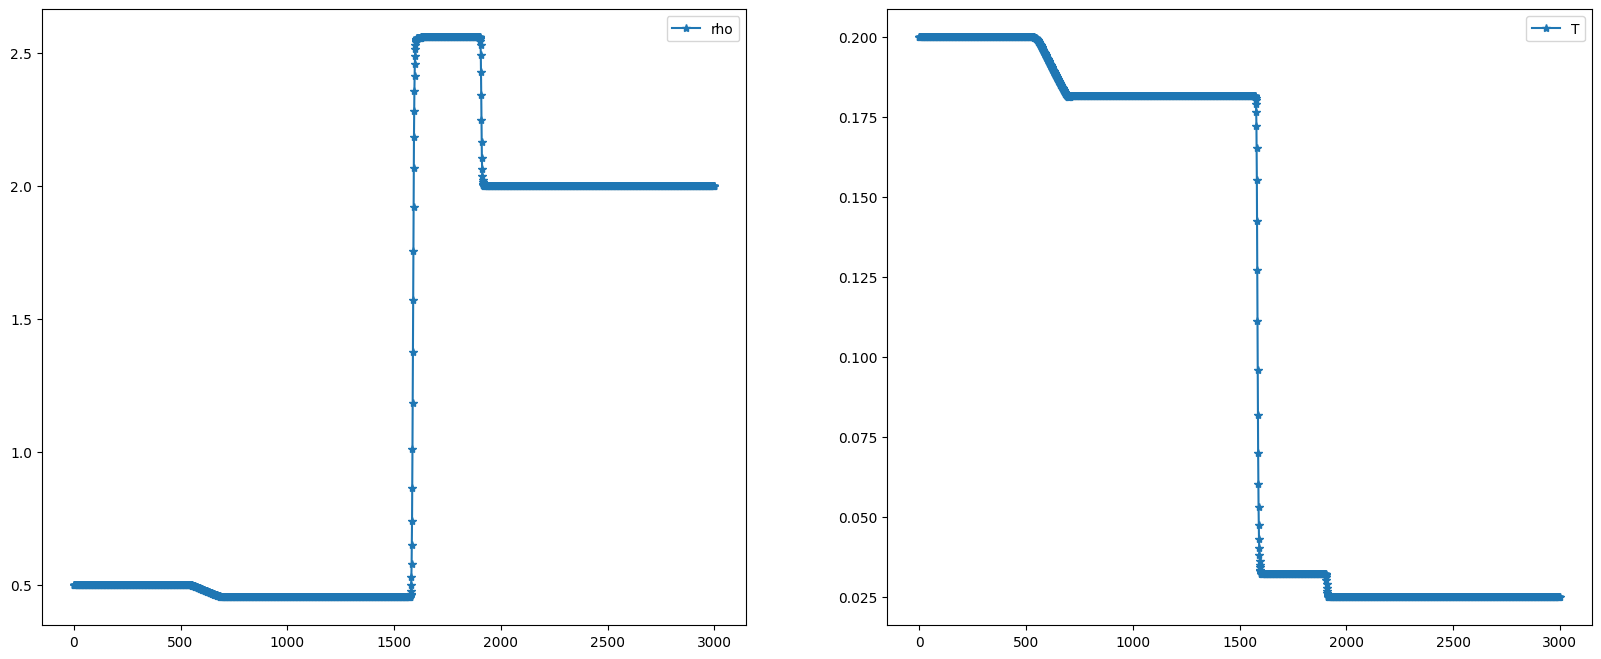

t= 1500.0


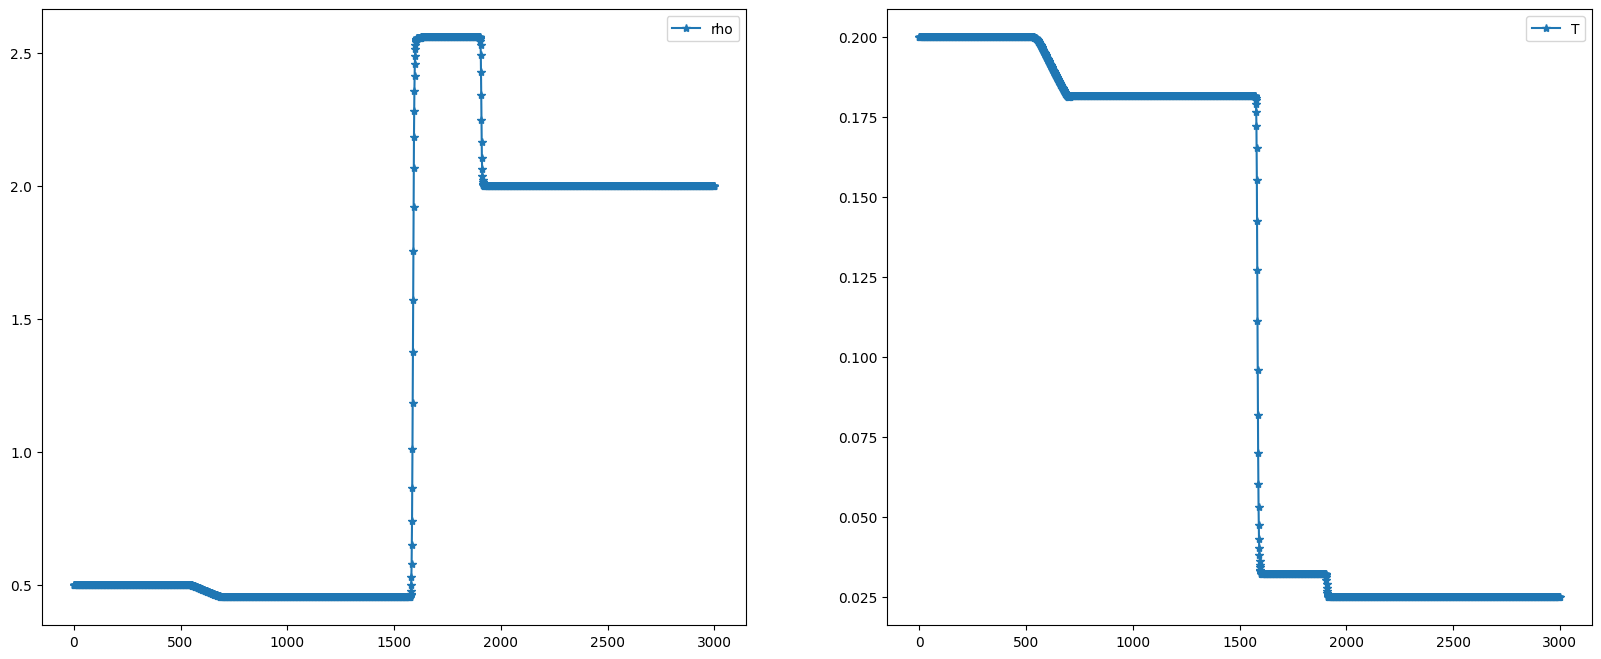

In [ ]:
#@title Sod setup
# sod
def stepLBMTwoPopStandardLattice(grid_f_in,grid_g_in):
    #allPeriodic
    grid_f_in=allPeriodicWithReturn(grid_f_in)
    grid_g_in=allPeriodicWithReturn(grid_g_in)

    #Zero gradient at left and right
    grid_f_in=xGradWithReturn(grid_f_in) #for sod
    grid_g_in=xGradWithReturn(grid_g_in) #for sod

    #advect
    grid_f_in=advectWithReturn(grid_f_in)
    grid_g_in=advectWithReturn(grid_g_in)

    #collide
    grid_f_in,grid_g_in=collideTwoPopStandardLatticeWithReturn(grid_f_in,grid_g_in)

    return grid_f_in,grid_g_in


maxTime=1500
nSteps=int(maxTime/dt) #int(0.20*(nZ/uz0)/dt)
limiter=vanLeer #vanLeer,monotonizedCentral,superbee

numberOfPlots=20
fig, ax = plt.subplots(1,2,figsize=(20,8))


startTimeOfDay = time.time()
for t in range(nSteps+1):

    if (((t*dt)%(maxTime/numberOfPlots))==0):

        plotRhoLive(ax[0])
        plotTLive(ax[1])
        display.clear_output(wait=True)
        display.display(plt.gcf())
        #fig.savefig('results/solution'+str(int(t*dt))+'.png')
        #writeToCSV()

        print('t=',t*dt)
        if (t>=nSteps):
            #display.clear_output(wait=True)
            break


    grid_f,grid_g=stepLBMTwoPopStandardLattice(grid_f,grid_g)

endTimeOfDay = time.time()

executionTime=endTimeOfDay - startTimeOfDay
MLUPS=2.0*(nSteps*nX*nY*nZ/executionTime)/1e6
#print('MLUPS=',MLUPS)

In [ ]:
#@title Viscosity test setup
# # viscosity test

# def stepLBMTwoPopStandardLattice(grid_f_in,grid_g_in):
#     #allPeriodic(grid_f)
#     grid_f_in=allPeriodicWithReturn(grid_f_in)
#     grid_g_in=allPeriodicWithReturn(grid_g_in)

#     #advect(grid_f)
#     grid_f_in=advectWithReturn(grid_f_in)
#     grid_g_in=advectWithReturn(grid_g_in)

#     #collide(grid_f)
#     grid_f_in,grid_g_in=collideTwoPopStandardLatticeWithReturn(grid_f_in,grid_g_in)

#     return grid_f_in,grid_g_in


# maxTime=5000
# nStep sending an abstract to DSFD 2021s=int(maxTime/dt) #int(0.20*(nZ/uz0)/dt)
# limiter=vanLeer #vanLeer,monotonizedCentral,superbee

# numberOfPlots=100
# fig, ax = plt.subplots(1,1,figsize=(20,8))

# tList=[]
# uxMaxList=[]

# startTimeOfDay = time.time()
# for t in range(nSteps+1):

#     if (((t*dt)%(maxTime/numberOfPlots))==0):

#         uxMax=plotUxLive(ax)
#         #plotTLive(ax[1])

#         display.clear_output(wait=True)
#         display.display(plt.gcf())
#         fig.savefig('results/solution'+str(int(t*dt))+'.png')
#         writeToCSV()

#         tList.append(t)
#         uxMaxList.append(uxMax)

#         print('t=',t*dt,', uxMax=',uxMax)
#         if (t>=nSteps):
#             #display.clear_output(wait=True)
#             break

#     #grid_f,grid_g=stepLBMTwoPop(grid_f,grid_g)
#     grid_f,grid_g=stepLBMTwoPopStandardLattice(grid_f,grid_g)

# endTimeOfDay = time.time()

# executionTime=endTimeOfDay - startTimeOfDay
# MLUPS=2.0*(nSteps*nX*nY*nZ/executionTime)/1e6
# print('MLUPS=',MLUPS)

In [ ]:
#@title Thermal Diffusivity test setup
# # thermal Diffusivity test

# def stepLBMTwoPopStandardLattice(grid_f_in,grid_g_in):
#     #allPeriodic(grid_f)
#     grid_f_in=allPeriodicWithReturn(grid_f_in)
#     grid_g_in=allPeriodicWithReturn(grid_g_in)

#     #advect(grid_f)
#     grid_f_in=advectWithReturn(grid_f_in)
#     grid_g_in=advectWithReturn(grid_g_in)

#     #collide(grid_f)
#     grid_f_in,grid_g_in=collideTwoPopStandardLatticeWithReturn(grid_f_in,grid_g_in)

#     return grid_f_in,grid_g_in


# maxTime=5000
# nSteps=int(maxTime/dt) #int(0.20*(nZ/uz0)/dt)
# limiter=vanLeer #vanLeer,monotonizedCentral,superbee

# numberOfPlots=100
# fig, ax = plt.subplots(1,1,figsize=(20,8))

# tList=[]
# TMaxList=[]

# startTimeOfDay = time.time()
# for t in range(nSteps+1):

#     if (((t*dt)%(maxTime/numberOfPlots))==0):

#         TMax=plotTLiveY(ax)
#         #plotTLive(ax[1])

#         display.clear_output(wait=True)
#         display.display(plt.gcf())
#         fig.savefig('results/solution'+str(int(t*dt))+'.png')
#         writeToCSV()

#         tList.append(t)
#         TMaxList.append(TMax)

#         print('t=',t*dt,', TMax=',TMax)
#         if (t>=nSteps):
#             #display.clear_output(wait=True)
#             break

#     #grid_f,grid_g=stepLBMTwoPop(grid_f,grid_g)
#     grid_f,grid_g=stepLBMTwoPopStandardLattice(grid_f,grid_g)

# endTimeOfDay = time.time()

# executionTime=endTimeOfDay - startTimeOfDay
# MLUPS=2.0*(nSteps*nX*nY*nZ/executionTime)/1e6
# print('MLUPS=',MLUPS)

Positions:
Head of Rarefaction : 0.18377223398316206
Foot of Rarefaction : 0.22841878108735808
Contact Discontinuity : 0.5297643647361306
Shock      : 0.6363334859985355
Regions:
Region 1   : (0.1, 0.5, 0.0)
Region 2   : RAREFACTION
Region 3   : (0.08246303682406858, 0.454045803923097, 0.05952872947226134)
Region 4   : (0.08246303682406858, 2.558592665183791, 0.05952872947226134)
Region 5   : (0.05, 2.0, 0.0)


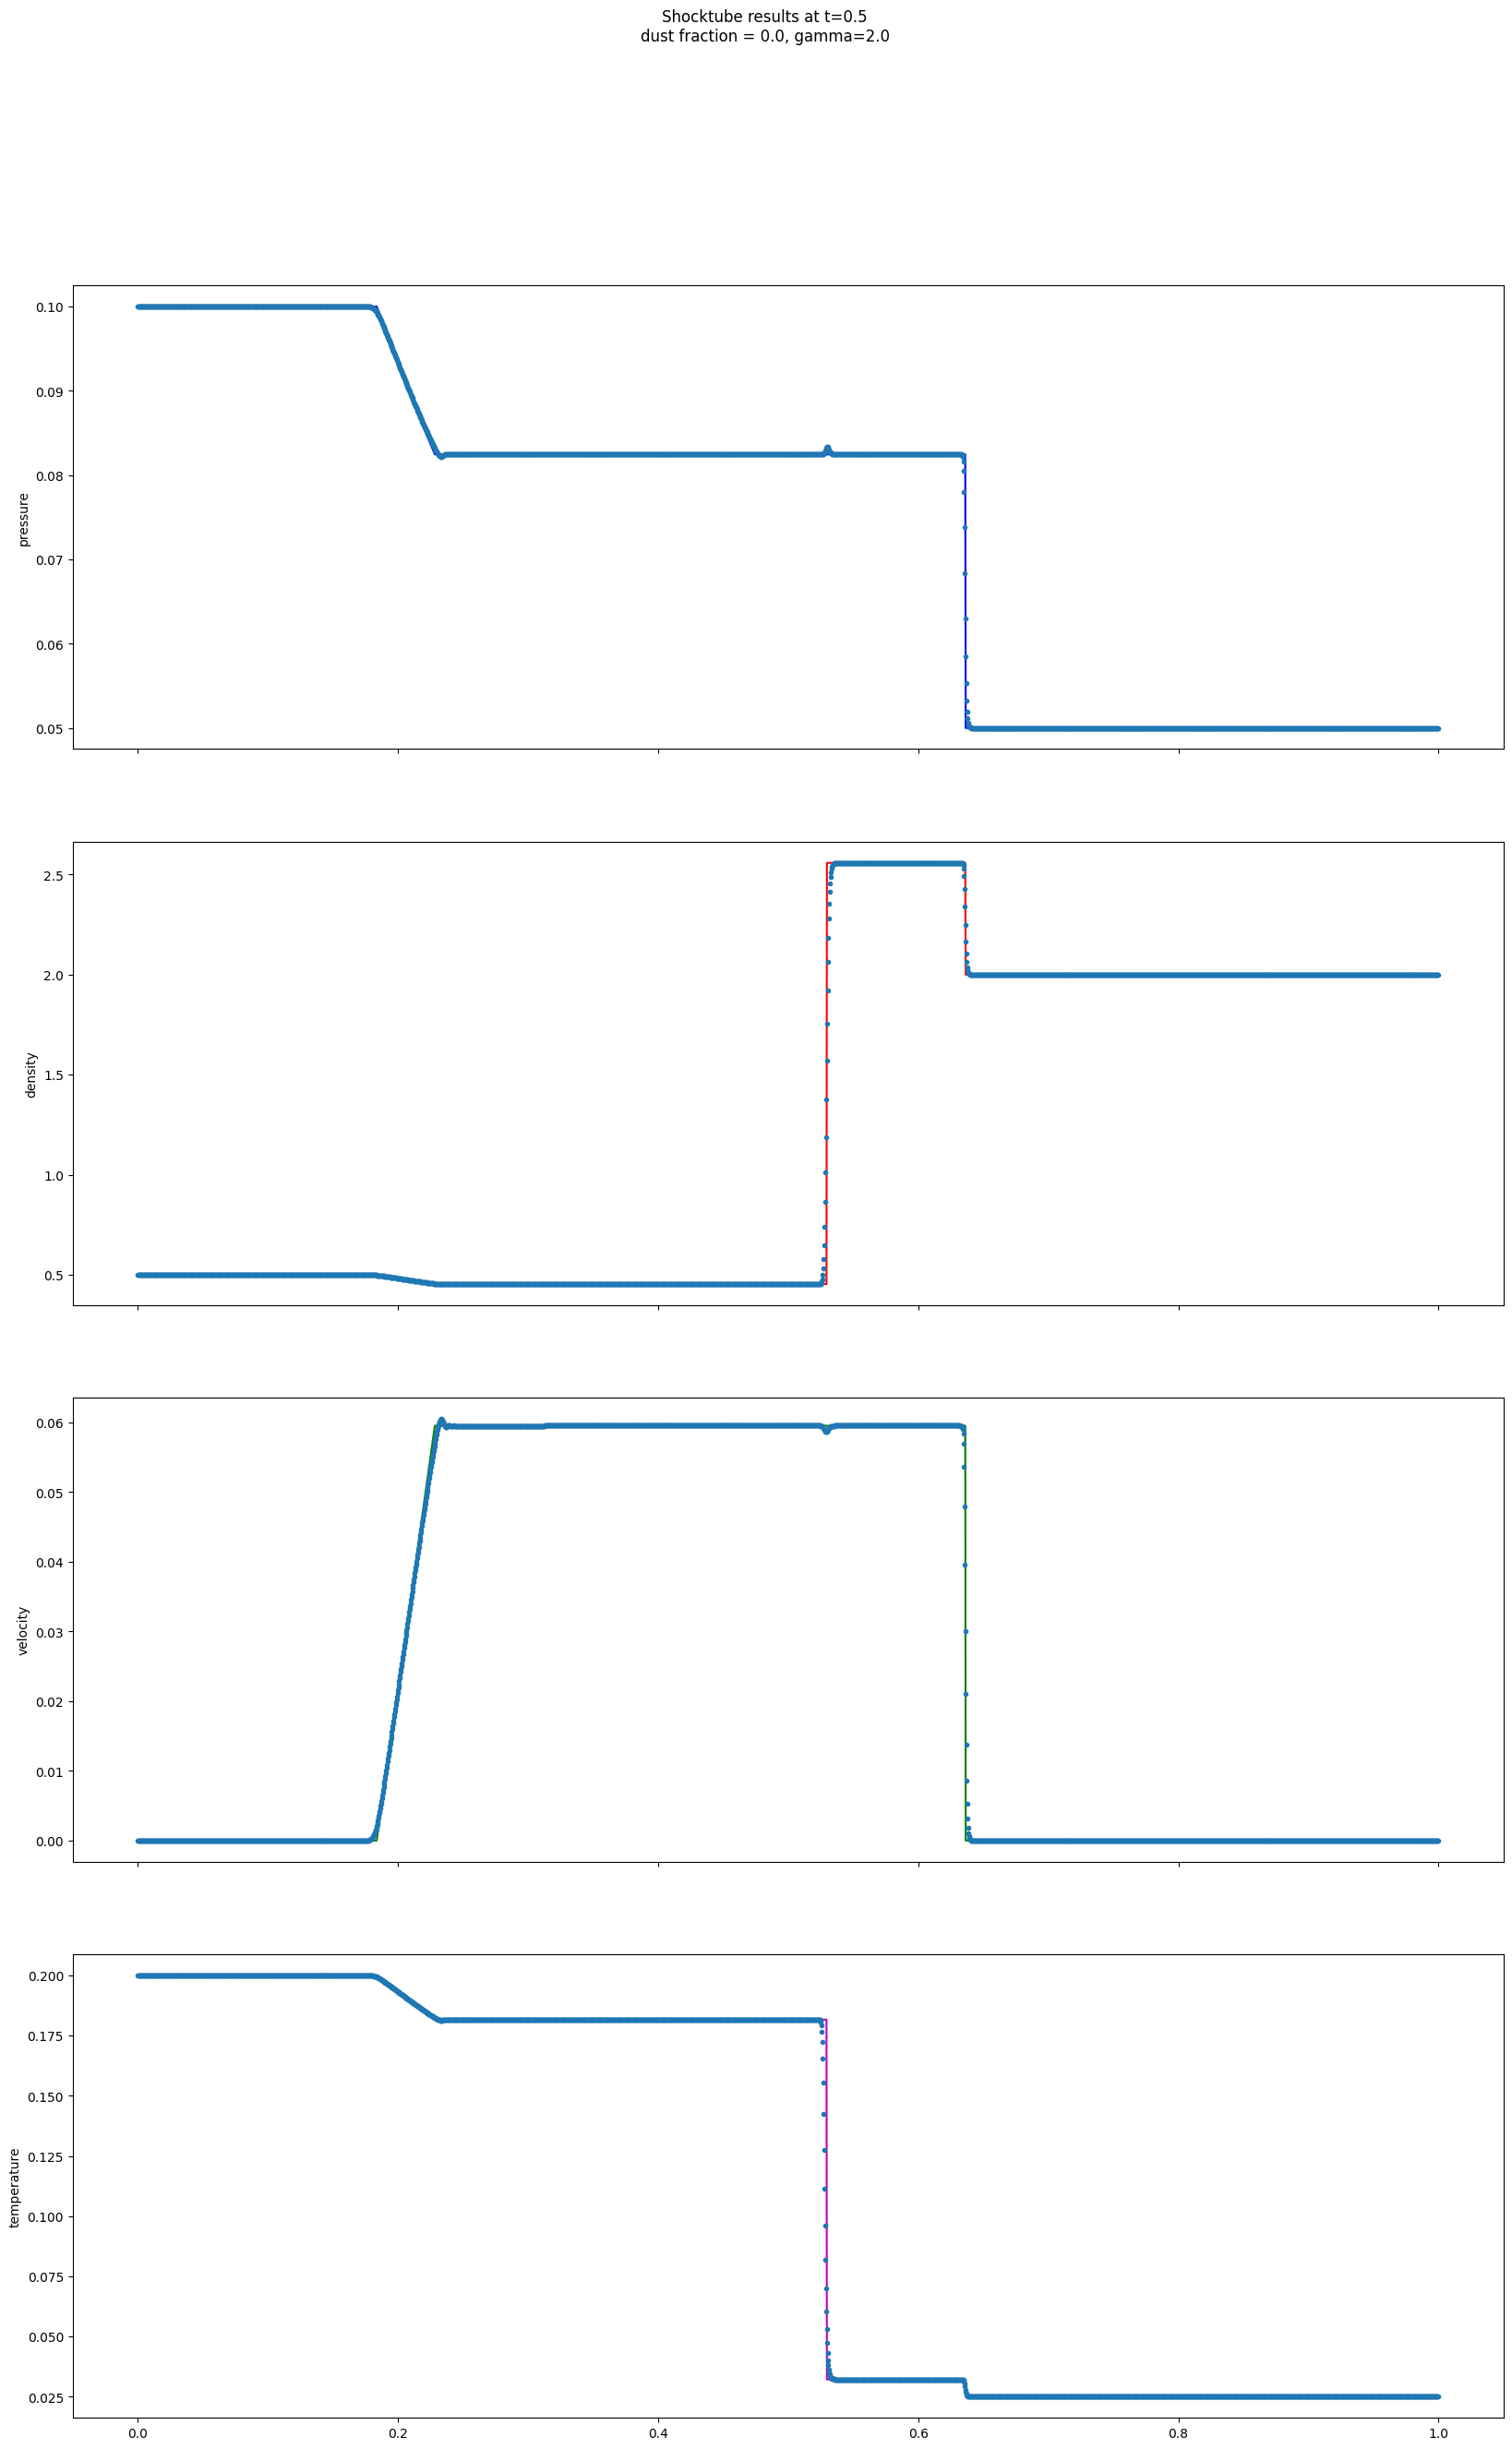

In [ ]:
#@title Plot LBM vs analytical (sod)
# sod
import sodshock

moments=(grid_f@matrixV)
g_moments=(grid_g@g_matrixV)

def sodAnalytical(maxTime):
    #gamma = 1.4
    dustFrac = 0.0
    npts = nX
    t = maxTime/nX
    rho_L=rho0
    rho_R=4.0*rho_L
    T_L=T0
    T_R=0.125*T_L
    left_state = (rho_L*T_L,rho_L,ux0) #P,rho,u
    right_state = (rho_R*T_R,rho_R,ux0)
    positions, regions, values = sodshock.solve(left_state=left_state, \
        right_state=right_state, geometry=(0., 1., 0.5), t=t,
        gamma=gamma, npts=npts, dustFrac=dustFrac)
    # left_state and right_state set pressure, density and u (velocity)
    # geometry sets left boundary on 0., right boundary on 1 and initial
    # position of the shock xi on 0.5
    # t is the time evolution for which positions and states in tube should be
    # calculated
    # gamma denotes specific heat
    # note that gamma and npts are default parameters (1.4 and 500) in solve
    # function
    positions, regions, values = sodshock.solve(left_state=left_state, \
        right_state=right_state, geometry=(0., 1., 0.5), t=t,
        gamma=gamma, npts=npts, dustFrac=dustFrac)
    # Printing positions
    print('Positions:')
    for desc, vals in positions.items():
        print('{0:10} : {1}'.format(desc, vals))

    # Printing p, rho and u for regions
    print('Regions:')
    for region, vals in sorted(regions.items()):
        print('{0:10} : {1}'.format(region, vals))


    # Finally, let's plot the solutions
    #f, axarr = plt.subplots(len(values)-1, sharex=True,figsize=(20, 20))
    f, axarr = plt.subplots(4, sharex=True,figsize=(20, 30))

    #f.figure(figsize=(20, 6), dpi=500)

    temperatureToPlot=getTemperature(g_moments[pZ+int(nZ/2),int(pY+nY/2),:,g_m.twoRhoE],
                        moments[pZ+int(nZ/2),int(pY+nY/2),:,m.rho],
                        moments[pZ+int(nZ/2),int(pY+nY/2),:,m.jx]/moments[pZ+int(nZ/2),int(pY+nY/2),:,m.rho],
                        moments[pZ+int(nZ/2),int(pY+nY/2),:,m.jy]/moments[pZ+int(nZ/2),int(pY+nY/2),:,m.rho],
                        moments[pZ+int(nZ/2),int(pY+nY/2),:,m.jz]/moments[pZ+int(nZ/2),int(pY+nY/2),:,m.rho],Cv)

    axarr[0].plot(values['x'], values['p'], linewidth=1.5, color='b')
    axarr[0].plot(asnumpy(np.arange(0,nX)*dx/nX),asnumpy(moments[pZ+int(nZ/2),int(pY+nY/2),pX:pX+nX,m.rho]*temperatureToPlot[pX:pX+nX]),'.',label='P')
    axarr[0].set_ylabel('pressure')

    axarr[1].plot(values['x'], values['rho'], linewidth=1.5, color='r')
    axarr[1].plot(asnumpy(np.arange(0,nX)*dx/nX),asnumpy(moments[pZ+int(nZ/2),int(pY+nY/2),pX:pX+nX,m.rho]),'.',label='rho')
    axarr[1].set_ylabel('density')

    axarr[2].plot(values['x'], values['u'], linewidth=1.5, color='g')
    axarr[2].plot(asnumpy(np.arange(0,nX)*dx/nX),asnumpy(moments[pZ+int(nZ/2),int(pY+nY/2),pX:pX+nX,m.jx]/moments[pZ+int(nZ/2),int(pY+nY/2),pX:pX+nX,m.rho]),'.',label='ux')
    axarr[2].set_ylabel('velocity')

    axarr[3].plot(values['x'], values['p']/values['rho'], linewidth=1.5, color='m')
    axarr[3].plot(asnumpy(np.arange(0,nX)*dx/nX),asnumpy(temperatureToPlot[pX:pX+nX]),'.',label='T')


    axarr[3].set_ylabel('temperature')


    plt.suptitle('Shocktube results at t={0}\ndust fraction = {1}, gamma={2}'\
                 .format(t, dustFrac, gamma))
    plt.show()

sodAnalytical(maxTime)

del moments
del g_moments


In [ ]:
#@title Plot viscosity test
# #viscosity test
# from scipy.optimize import curve_fit

# uxMaxArray=np.asarray(uxMaxList)/uxMaxList[0]
# tArray=np.asarray(tList)

# uxMaxArray=asnumpy(uxMaxArray)
# tArray=asnumpy(tArray)

# #print(type(uxMaxArray),type(tArray))

# def fit(t_,a_):
#     return npcpu.exp(-a_*t_)

# popt,pcov=curve_fit(fit,tArray,uxMaxArray,p0=0.0001)

# plt.plot(tArray,uxMaxArray,'-')
# plt.plot(tArray,fit(tArray,popt[0]),'.')
# nuRecovered=popt[0]/pow((2.0*np.pi/nY),2)
# print('nu recovered is',nuRecovered)
# np.savetxt('results/timeViscosity.csv',np.array([tArray,uxMaxArray]).T,delimiter=',')

In [ ]:
#@title Plot thermal Diffusivity test
# #thermal Diffusivity test
# from scipy.optimize import curve_fit

# TMaxArray=np.asarray(TMaxList)-T0
# TMaxArray=TMaxArray/TMaxArray[0]
# tArray=np.asarray(tList)

# TMaxArray=asnumpy(TMaxArray)
# tArray=asnumpy(tArray)

# def fit(t_,a_):
#     return npcpu.exp(-a_*t_)

# popt,pcov=curve_fit(fit,tArray,TMaxArray,p0=0.0001)

# plt.plot(tArray,TMaxArray,'-')
# plt.plot(tArray,fit(tArray,popt[0]),'.')
# alphaRecovered=popt[0]/pow((2.0*np.pi/nY),2)
# print('alpha recovered is',alphaRecovered)
# np.savetxt('results/timeThermalDiffusivity.csv',np.array([tArray,TMaxArray]).T,delimiter=',')